In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance, distance_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import matplotlib.pyplot as plt
from collections import Counter
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
%matplotlib inline

## Creation some help functions

In [2]:
class Color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

    
# function allows to print colorful and bold text
def pretty_print(text="", text_headers="", color="", bold=False):
    bold_part = Color.BOLD if bold else ""
    color_part = Color.__dict__.get(color.upper(), "")
    print(bold_part + color_part + text_headers + Color.END + text)
    
# create hist of data
def show_hist(data, title="", xlabel="", ylabel="", grid=False):
    fig, ax = plt.subplots()
    ax.hist(data)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(grid)
    
# create hist of binary data
def show_binary_hist(data, title="", xlabel="", ylabel="", grid=False):
    fig, ax = plt.subplots()
    ax.hist(data, bins=(-0.25, 0.25, 0.75, 1.25))
    plt.xticks((0,1))
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(grid)

## Data loading from scv files
1. all_data - data of morning and afternoon datasets
2. morning_data - data of morning dataset
3. afternoon_data - data of afternoon dataset

In [3]:
separator = ';'
all_data = pd.read_csv("all_data.csv", sep=separator)
morning_data = pd.read_csv("morning_data.csv", sep=separator)
afternoon_data =pd.read_csv("afternoon_data.csv", sep=separator)
datasets = [all_data, morning_data, afternoon_data]

## Data engineering

In [4]:
def dataset_engineering(df):
    df["code_mkb10"] = df["code_mkb10"].apply(str)  # conversion of column code_mkb10 to string type
    
    # adding new column [0, 1] cardio_desease from column code_mkb10 (if code start with I, then 1, else 0)
    df["cardio_desease"] = df["code_mkb10"].apply(lambda x: 1 if x[0] == "I" else 0)    
    df.drop(["code_mkb10"], inplace=True, axis=1)

In [5]:
for dataset in datasets:
    dataset_engineering(dataset)

## Functions for description of data

In [6]:
def describe_data(df, headers_color="", headers_bold=False):
    pretty_print(str(df.shape[0]), "Number of ECG: ", headers_color, headers_bold)
    
    with_desease = str(len(df['respiratory_disease'][df['respiratory_disease'] == 1]))
    pretty_print(with_desease, "Number of ECG with desease: ", headers_color, headers_bold)
    
    without_desease = str(len(df['respiratory_disease'][df['respiratory_disease'] != 1]))
    pretty_print(without_desease, "Number of ECG without desease: ", headers_color, headers_bold)
    
    patients = str(len(df["patient_id"].unique()))
    pretty_print(patients, "Number of patiants: ", headers_color, headers_bold)
    
    patients_with_desease = str(len(df["patient_id"][df["respiratory_disease"] == 1].unique()))
    pretty_print(patients_with_desease, "Number of patiants with respiratory desease: ", headers_color, headers_bold)
    
    patients_without_desease = str(len(df["patient_id"][df["respiratory_disease"] != 1].unique()))
    pretty_print(patients_without_desease, "Number of patiants with respiratory desease: ", headers_color, headers_bold)
    
    show_hist(df["age"], "Patient age hist", "Age", "Amount")
    show_binary_hist(df["gender"], "Patient gender hist", "Gender", "Amount")
    show_binary_hist(df["smoking"], "Patient smoking hist", "Smoking", "Amount")
    show_binary_hist(df["cardiostimulator"], "Patient cardiostimulator hist", "Cardiostimulator", "Amount")
    show_binary_hist(df["diseasediabetes"], "Patient diseasediabetes hist", "Diabete", "Amount")
    show_binary_hist(df["diseasehypertonia"], "Patient diseasehypertonia hist", "Hypertonia", "Amount")
    show_binary_hist(df["cardio_desease"], "Patient cardio_desease hist", "Cardio desease", "Amount")
    
    patients_with_cardio_desease = df["respiratory_disease"][df["cardio_desease"] == 1]
    show_binary_hist(patients_with_cardio_desease, "Patient resperatory deseases with cardio desease hist",
                     "Respiratory desease", "Amount")
    
    patients_without_cardio_desease = df["respiratory_disease"][df["cardio_desease"] != 1]
    show_binary_hist(patients_without_cardio_desease, "Patient resperatory deseases without cardio desease hist",
                     "Respiratory desease", "Amount")

In [7]:
def research_data(df, headers_color="", headers_bold=False):
    pretty_print(text_headers="First 5 strings of dataset", color=headers_color, bold=headers_bold)
    print(df.head())
    
    pretty_print(text_headers="Null values in data", color=headers_color, bold=headers_bold)
    print(np.sum(df.isnull()))
    

## Description of all_data

Number of ECG: 15436
Number of ECG with desease: 14383
Number of ECG without desease: 1053
Number of patiants: 301
Number of patiants with respiratory desease: 161
Number of patiants with respiratory desease: 140


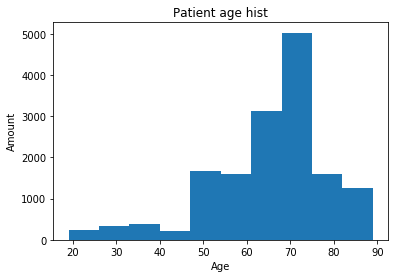

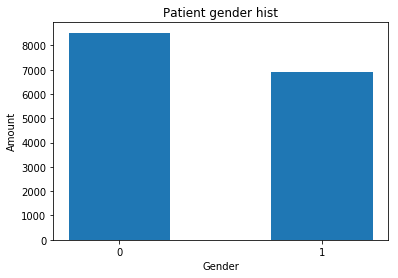

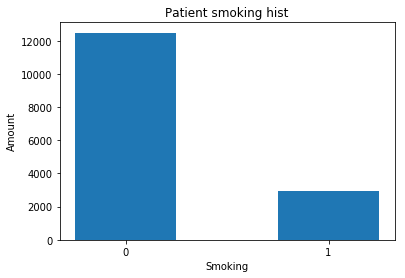

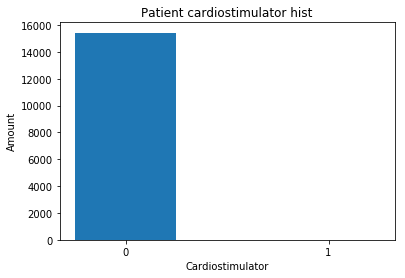

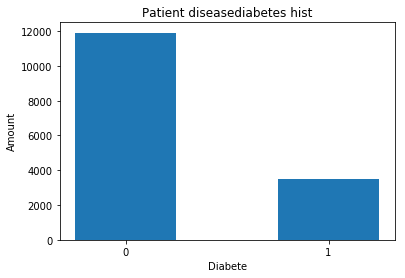

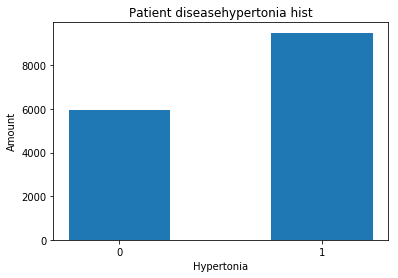

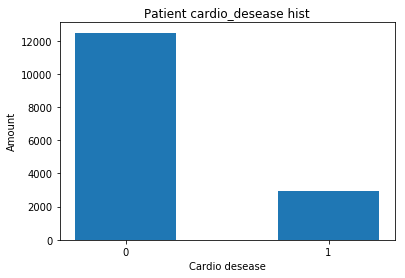

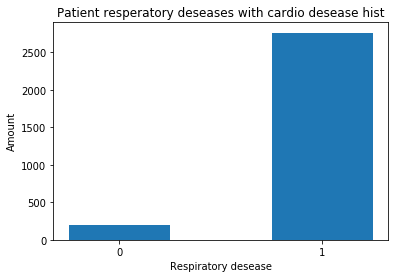

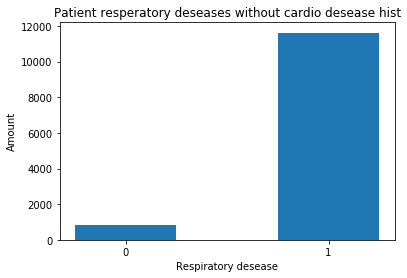

In [8]:
describe_data(all_data, "red")

In [9]:
research_data(all_data, "red", True)

First 5 strings of dataset
   patient_id     cid             date1  age  gender  weight  height  \
0       11470  117686   23.09.2019 8:34   89       0      54     154   
1       11470  117354  19.09.2019 12:39   89       0      54     154   
2       11470  117734  23.09.2019 12:13   89       0      54     154   
3       11470  117431   20.09.2019 8:36   89       0      54     154   
4       11470  117481  20.09.2019 13:04   89       0      54     154   

   cardiostimulator  smoking  diseasediabetes      ...                   tpw  \
0                 0        0                1      ...        139,9216800000   
1                 0        0                1      ...        149,7740000000   
2                 0        0                1      ...        223,9548000000   
3                 0        0                1      ...         52,8759350000   
4                 0        0                1      ...        224,9972500000   

            vlfw         vlfpw          lfpw            brw

## Description of morning_data

Number of ECG: 8020
Number of ECG with desease: 7461
Number of ECG without desease: 559
Number of patiants: 230
Number of patiants with respiratory desease: 161
Number of patiants with respiratory desease: 69


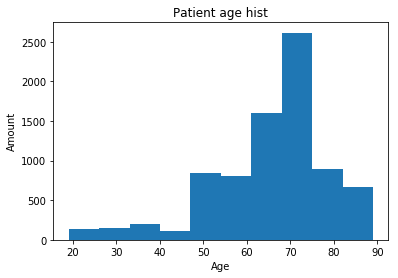

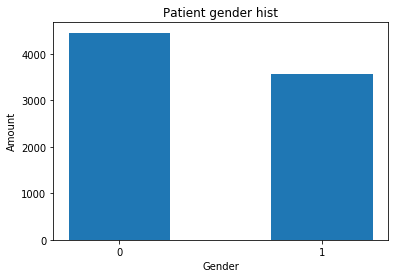

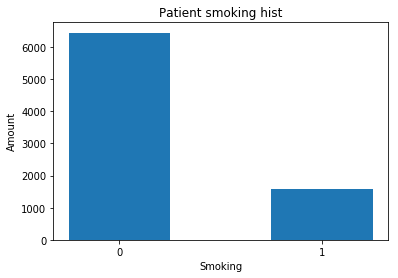

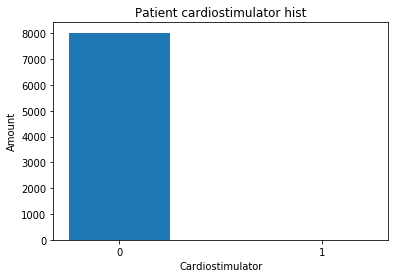

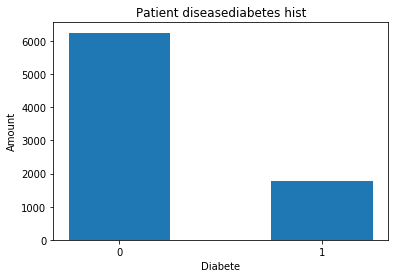

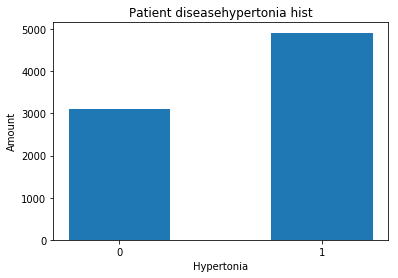

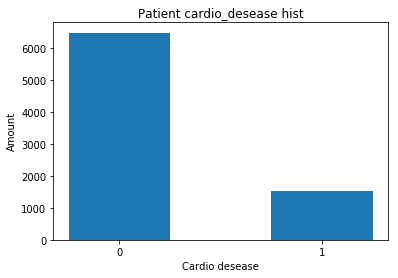

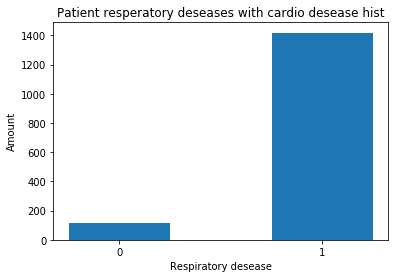

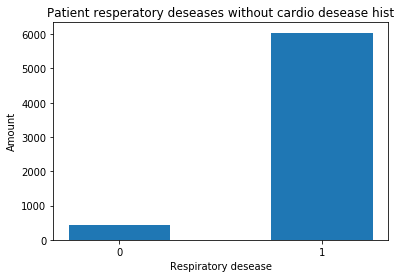

In [10]:
describe_data(morning_data, "red")

In [11]:
research_data(morning_data, "red", True)

First 5 strings of dataset
   patient_id     cid            date1  age  gender  weight  height  \
0       11470  117686  23.09.2019 8:34   89       0      54     154   
1       11470  117431  20.09.2019 8:36   89       0      54     154   
2       11470  117971  25.09.2019 8:36   89       0      54     154   
3       11470  117834  24.09.2019 8:39   89       0      54     154   
4       11470  117686  23.09.2019 8:34   89       0      54     154   

   cardiostimulator  smoking  diseasediabetes      ...                   tpw  \
0                 0        0                1      ...        139,9216800000   
1                 0        0                1      ...         52,8759350000   
2                 0        0                1      ...        161,1131000000   
3                 0        0                1      ...        178,9474200000   
4                 0        0                1      ...        139,9216800000   

            vlfw         vlfpw          lfpw            brw      

## Description of afternoon_data

Number of ECG: 7416
Number of ECG with desease: 6922
Number of ECG without desease: 494
Number of patiants: 236
Number of patiants with respiratory desease: 161
Number of patiants with respiratory desease: 75


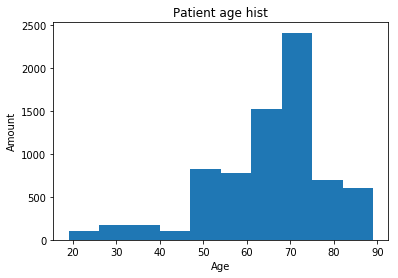

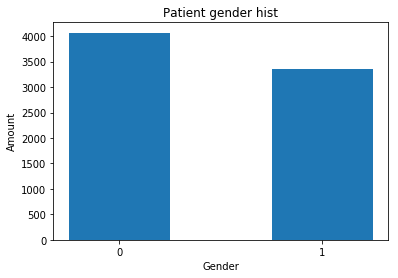

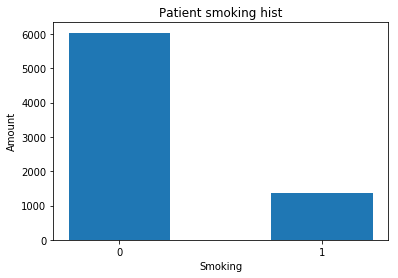

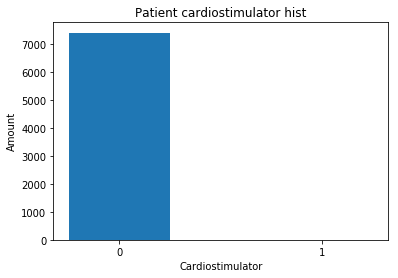

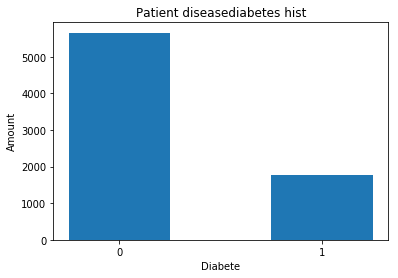

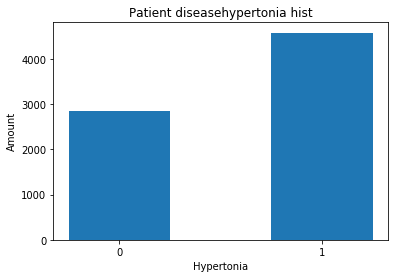

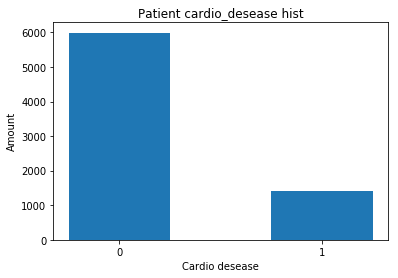

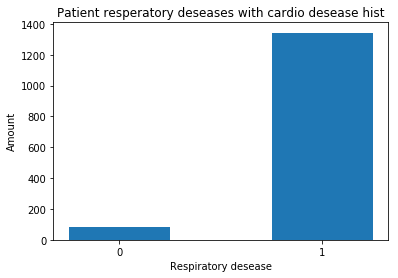

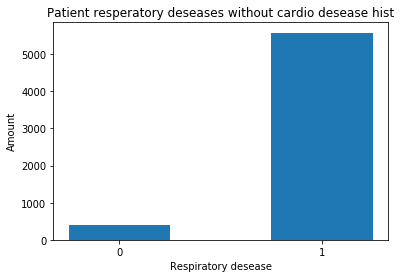

In [12]:
describe_data(afternoon_data, "red")

In [13]:
research_data(afternoon_data, "red", True)

First 5 strings of dataset
   patient_id     cid             date1  age  gender  weight  height  \
0       11470  117354  19.09.2019 12:39   89       0      54     154   
1       11470  117734  23.09.2019 12:13   89       0      54     154   
2       11470  117481  20.09.2019 13:04   89       0      54     154   
3       11470  117892  24.09.2019 13:23   89       0      54     154   
4       11470  117354  19.09.2019 12:39   89       0      54     154   

   cardiostimulator  smoking  diseasediabetes      ...                   tpw  \
0                 0        0                1      ...        149,7740000000   
1                 0        0                1      ...        223,9548000000   
2                 0        0                1      ...        224,9972500000   
3                 0        0                1      ...        206,7881500000   
4                 0        0                1      ...        149,7740000000   

            vlfw         vlfpw          lfpw            brw

# Models

In [22]:
def create_data_for_model(df):
    y = df["respiratory_disease"]
    df.drop(["respiratory_disease"], inplace=True, axis=1)
    return train_test_split(df, y, test_size=0.3)

In [19]:
X_train, X_test, y_train, y_test = create_data_for_model(all_data)

In [6]:
def string_preprocessing(string):
        
    def change_double_dot_floats(element):
        counter = Counter(list(element))
        if counter["."] > 1:
            second_dot_index = element.rfind(".")
            element_list = list(element)
            element_list[second_dot_index] = ""
            element = ''.join(element_list)
        return element  
    
    if not pd.isnull(string):
        string = string.replace(",", ".")
        string = change_double_dot_floats(string)
        string = float(string)
    return string
        
def dataset_preprocessing(df):
    date_column = df.date1
    df.drop(["date1"], inplace=True, axis=1)
    
    for column in df.columns:
        if type(df[column][0]) == str:
            try:
                df[column] = df[column].apply(lambda x: string_preprocessing(x))
            except:
                print(df[column])

In [66]:
def most_appropriate_string(df_without_none, string_with_nan):
    string_euclidean_distances = euclidean_distances(string_with_nan, df_without_none) 
    string_euclidean_distances = string_euclidean_distances.reshape(string_euclidean_distances.shape[1],)
    string_cosine_distances = cosine_distances(string_with_nan, df_without_none) 
    string_cosine_distances = string_cosine_distances.reshape(string_cosine_distances.shape[1],)
    min_euclidian_distance_string_index = np.where(string_euclidean_distances == min(string_euclidean_distances))[0][0]
    min_cosine_distance_string_index = np.where(string_cosine_distances == min(string_cosine_distances))[0][0]
    # one more criteria
    
    strings_indexes = [min_euclidian_distance_string_index, min_cosine_distance_string_index]
    
    print(strings_indexes)
    counter = Counter(strings_indexes)
    real_string_index = counter.most_common(1)[0]
    return real_string_index
            
def replace_nan_by_closest_vector(df):
    columns_with_nan = [column for column in df.columns if np.sum(df[column].isnull()) != 0]
    df_without_none = df.drop(df[columns_with_nan], axis=1)
    all_nan_indexes = set()
    for column_with_nan in columns_with_nan:
        nan_indexes = set(sum(np.argwhere(pd.isnull(df[column_with_nan])).tolist(), []))
        all_nan_indexes = all_nan_indexes.union(nan_indexes)
    all_nan_indexes = list(all_nan_indexes)
    strings_with_nan = [df_without_none.loc[nan_index] for nan_index in all_nan_indexes]
    df_without_none.drop(df_without_none.index[all_nan_indexes], inplace=True, axis=0)
    

In [67]:
#         for string_with_nan in strings_with_nan:
#             most_closest_string_index = most_appropriate_string(df_without_none, string_with_nan)
#             # change nan values in real_dtaset by values of closest strings
  

In [68]:
df = deepcopy(all_data)
dataset_preprocessing(df)

In [69]:
columns_with_nan = [column for column in df.columns if np.sum(df[column].isnull()) != 0]
df_without_none = df.drop(df[columns_with_nan], axis=1)

In [70]:
all_nan_indexes = set()
for column_with_nan in columns_with_nan:
    nan_indexes = set(sum(np.argwhere(pd.isnull(df[column_with_nan])).tolist(), []))
    all_nan_indexes = all_nan_indexes.union(nan_indexes)
all_nan_indexes = list(all_nan_indexes)

/home/gleb/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


In [71]:
strings_with_nan = [df_without_none.loc[nan_index] for nan_index in all_nan_indexes]
df_without_none.drop(df_without_none.index[all_nan_indexes], inplace=True, axis=0)

In [42]:
test_str = strings_with_nan[0].values.reshape(1, -1)

In [51]:
string_euclidean_distances = euclidean_distances(test_str, df_without_none) 
string_euclidean_distances = string_euclidean_distances.reshape(string_euclidean_distances.shape[1],)
string_euclidean_distances.shape

(12885,)

In [64]:
min_euclidian_distance_string_index = np.where(string_euclidean_distances == min(string_euclidean_distances))[0][0]

In [65]:
min_euclidian_distance_string_index

165

In [61]:
string_euclidean_distances[215]

747.5435105881107

In [46]:
min_euclidian_distance_string_index

(array([ 165,  175,  185,  215, 6629, 6649, 6659, 6669]),)

In [35]:
min(string_euclidean_distances)

747.5435105881107

In [73]:
index = most_appropriate_string(df_without_none, strings_with_nan[0].values.reshape(1, -1))
index

[165, 7109]


(165, 1)

In [74]:
strings_with_nan[0]

patient_id         11550.000000
cid               117888.000000
age                   82.000000
gender                 1.000000
weight                70.000000
                      ...      
ulfpw                  0.002888
icw                    4.417210
hfw                   59.717970
tpfullw               86.969080
cardio_desease         0.000000
Name: 8192, Length: 72, dtype: float64

In [76]:
df_without_none.loc[165]

patient_id         11525.000000
cid               118109.000000
age                   72.000000
gender                 1.000000
weight                80.000000
                      ...      
ulfpw                  0.007179
icw                    5.931001
hfw                  119.966810
tpfullw              302.612270
cardio_desease         0.000000
Name: 165, Length: 72, dtype: float64

In [77]:
a = [column for column in all_data.columns if np.sum(all_data[column].isnull()) != 0] 
a
t = np.array(all_data['p_left_slopes'])
r = np.array(t).reshape(-1, 1)

In [18]:
a = [3, 5, 6]
b = [3, 5, 2]
c = [3, 5, 6]
d = [3, 1, 1]
k = [a, b, c, d]

In [21]:
l = [[1, 1, 1]]

In [15]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances

In [41]:
a = [3, 4, 3, 5]


In [28]:
a = np.ndarray([3])
a[1] = 6

In [31]:
np.where(a == 1)

(array([0, 2]),)

In [83]:
all_data['p_left_slopes'][]

nan

In [20]:
RFC = RandomForestClassifier()

In [21]:
RFC.fit(X_train, y_train)
y_hat = RFC.predict(X_test)

ValueError: could not convert string to float: '9420,0090000000'

In [26]:
a = all_data.loc[0]
b = all_data.loc[1]

In [27]:
distance.cosine(a, b)

TypeError: can't multiply sequence by non-int of type 'str'